# Naive quiz contract or something more?

Take a look at this contract: `0xb6A3dd14816BDB3C51188f8F24265284F6461939` ([Etherscan](https://goerli.etherscan.io/address/0xb6a3dd14816bdb3c51188f8f24265284f6461939)).

The contract is verified on Etherscan and the code is provided below for convenience:

```javascript
// SPDX-License-Identifier: UNLICENSED
pragma solidity =0.8.18;

contract Quiz {
    uint256 public constant PAYMENT = 0.05 ether;

    string public question;
    bytes32 answerHash;
    address owner;
    mapping(address => bool) paid;

    // Before each attempt, you must call payment and pay the fee
    function payment() public payable {
        require(
            msg.value == PAYMENT,
            "Must pay exactly PAYMENT ether to register"
        );
        paid[msg.sender] = true;
    }

    // Call this function to attempt to answer the question
    // Make sure you call payment() before each call to this function
    function answer(string calldata _answer) public {
        require(
            paid[tx.origin],
            "You must first call payment() with PAYMENT ether attached"
        );

        // If you guess correctly, you get all the funds in the contract!
        // If you guess incorrectly, half your payment will be returned to you, the other half will be kept in the contract
        if (keccak256(bytes(_answer)) == answerHash) {
            // send all funds in this contract to caller
            msg.sender.call{value: address(this).balance}("");
        } else {
            // send only half the caller's payment back
            msg.sender.call{value: PAYMENT / 2}("");
            paid[msg.sender] = false;
        }
    }

    // Below functions are for setup and are restricted to isOwner

    function setQuestion(string calldata _question, string calldata _answer)
        public
        payable
        isOwner
    {
        question = _question;
        answerHash = keccak256(bytes(_answer));
    }

    function setQuestionWithHash(string calldata _question, bytes32 _answerHash)
        public
        isOwner
    {
        question = _question;
        answerHash = _answerHash;
    }

    function endQuestion() public isOwner {
        payable(owner).transfer(address(this).balance);
    }

    modifier isOwner() {
        require(tx.origin == owner);
        _;
    }

    constructor() payable {
        owner = msg.sender;
    }
}
```

Take some time to read through the code of the contract and make sure you fully understand how it works.

Note that the contract currently holds a balance of 1 ETH. Based on the code, it appears that the creator sets a question and answer using `setQuestion()` and anyone who correctly answers the question using `answer()` will get the full balance of the contract: 1 ETH for free.

We see that there was a transaction that called `setQuestion()` shortly after the contract was deployed. Since the contract is verified, we can see what arguments were passed to it. Go to the [transaction on Etherscan](https://goerli.etherscan.io/tx/0xa07f080fcd33081e1ca0ac690420f230eac5bb17c7b0f0d99e0fee7fff739bad) and click "Click to show more" and then "Decode Input Data". You should see the following:


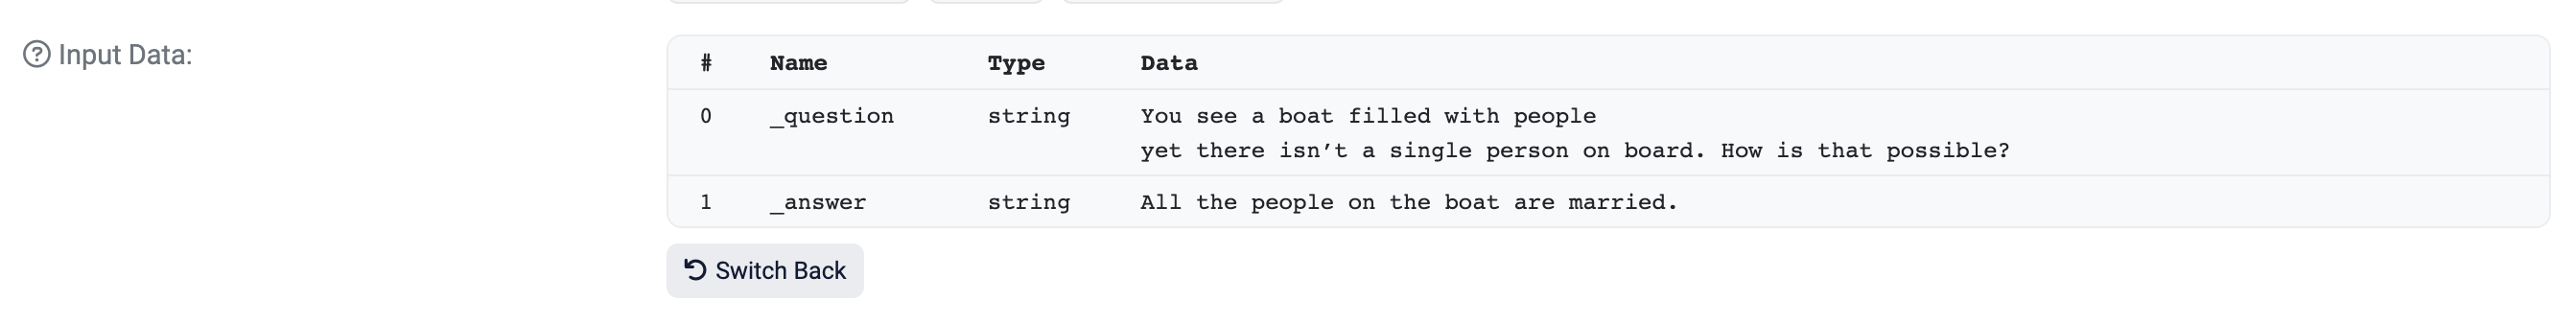

As described in the code comments, the Quiz contract works as follows for players:


*   Call `payment()` and include the required payment of exactly `0.05` ETH
*   Call `answer()` and provide your answer

Note that a call to `payment()` is required before every call to `answer()`.

#### Objective

We would like to get the 1 ETH sitting in the contract. Extract it from the contract in any way possible.

HINTS: https://docs.google.com/document/d/1ymo_9Obu1Cu56yfh2IdRK4LEs5OATqZsORyStriW2z4/edit?usp=sharing